In [0]:
# !rm da*
# !rm mem*
# !rm sim*

from __future__ import absolute_import
from __future__ import print_function

from sklearn import metrics
# from memn2n import MemN2N
from itertools import chain
from six.moves import range, reduce
import re

import tensorflow as tf
from tensorflow import keras

import numpy as np

from google.colab import files

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

# uploaded = files.upload()
# uploaded = None

In [0]:
re.findall(r'\bx\b', 'line In the figure above , what is the value of x ?')



# re.findall(r'(\b([A-Z]+)\b)|(\bx\b)', 'line In the figure above , what is the value of y ?')

# re.findall(r'\b([A-Z]+)\b', 'line In the figure above , what is A the BC value of x ?')
x = 33
if (not x ==3):
  print('dd')

dd


In [0]:
# ############################ data utils

def load_task3(train_file, only_supporting=False, test_count=10):
    #   filter for binary rules
    train2_data = list()
    for line in train_file:
        line = line.replace('\n', '')
        #     line = str.lower(line)
        # 		line = str.lower(line)
        print(line)
        _, qna = line.split('##')
        if (len(qna.split(' ')) == 2):
            #             print('line ',line)
            train2_data.append(line)

    train_data = parse_stories3(train2_data[:-1 * test_count], -1, only_supporting)
    test_data = parse_stories3(train2_data[-1 * test_count:], -1, only_supporting)
    print('lens', len(train2_data), '#', len(train_data), '#', len(test_data))
    return train_data, test_data


# len(parse_stories(train_data[:-11], False)),len(parse_stories(train_data[-11:], False))

def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories3(lines, q_position=-1, only_supporting=False):
    '''Parse stories provided in the bAbI tasks format
    If only_supporting is true, only the sentences that support the answer are kept.
    '''
    # In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD

    data = []
    story = []
    for line in lines:
        if(len(lines)>1):
            q_position = -1
        #     print('parseLine', line)
        story = []
        line = line.replace('\n', '')
        #     line = str.lower(line)
        # 		line = str.lower(line)
        #         print line
        fact1, qna = line.split('##')
        # q, a, supporting = line.split('\t')

        #     a = tokenize(a)

        fact1 = tokenize(fact1)
        if fact1[-1] == "?" or fact1[-1] == ".":
            fact1 = fact1[:-1]

        for word in fact1:
            story.append(word)
        # story.append(fact1)
        # a = tokenize(a)
        # answer is one vocab word even if it's actually multiple words
        #     a = [a]
#         print('qna', qna)
        qna = qna.split(' ')
        if (len(qna) == 2):
            q1, a1 = qna[:-1], qna[-1:]
            if not re.search(r'\b(([A-Z]+)|([a-z]))\b', a1[0]):
                continue
            q1 = ' '.join(q1)
            q1 = tokenize(q1)
#             print('fact1, q1, a1', fact1, a1, q1)
            min_dis = 0
#             print('q_position 0 ', q_position)
            if (q_position == -1):
                q_position, a_index, min_dis = get_q_index(fact1, a1, q1)
#                 print(q_position, a_index, min_dis)
                if (min_dis == 0):
                    continue
#             print('story, a1, q1, q_position', story,'\n', a1,'\n', q1,'\n', q_position)
            data.append((story, a1, q1, q_position))
    return data


def vectorize_datas(data, word_idx, sentence_size, memory_size, q_position=-1):
    """
    Vectorize stories and queries.

    If a sentence length < sentence_size, the sentence will be padded with 0's.

    If a story length < memory_size, the story will be padded with empty memories.
    Empty memories are 1-D arrays of length sentence_size filled with 0's.

    The answer array is returned as a one-hot encoding.
    """
    S = []
    Q = []
    A = []
    print('data', data)
    for story, query, answer, q_position in data:
        # 		print('story', story)
        # story ['In', 'the', 'accompanying', 'diagram', 'of', 'circle', 'O', ',', 'the', 'measure', 'of', 'angle', 'ABC', 'is', '@', 'v_0', 'and', 'the', 'measure', 'of', 'arc', 'AC', 'is', '@', 'v_1']

        if (q_position == -1):
            q_position = story.index(query[0])

        if (answer[0] not in story):
            continue
        ss = []
        for i, sentence in enumerate(story, 1):
            ls = 1
            # 			print('ls, sentence_size, sentence', ls, sentence, sentence_size, query)
            #       ls, sentence_size, sentence 1 accompanying 2 ['is']
            ss.append([word_idx[sentence]] + [0] * ls)
        # print('[word_idx[sentence]] + [0] * ls', [word_idx[sentence]] + [0] * ls)
        # 			print('ss', ss)

        # take only the most recent sentences that fit in memory
        ss = ss[::-1][:memory_size][::-1]

        # Make the last word of each sentence the time 'word' which
        # corresponds to vector of lookup table
        print('q_position_1', q_position)
        ss[q_position][-1] = len(word_idx) - memory_size
        # 		print('ss[q_position][-1] ', ss[q_position][-1], q_position )
        count = 0
        for i in range(q_position - 1, -1, -1):
            count += 1
            # 			print('i', i, ss[q_position][-1] - count)

            ss[i][-1] = ss[q_position][-1] - count

        count = 0
        for j in range(q_position + 1, len(ss)):
            count += 1
            # 			print('j', j, ss[q_position][-1] + count)

            ss[j][-1] = ss[q_position][-1] + count

        # print()

        # 		for i in range(len(ss)):
        # 			ss[i][-1] = len(word_idx) - memory_size - i + len(ss)
        #       i - q_position
        # 		print('ss1', ss)
        # pad to memory_size
        lm = max(0, memory_size - len(ss))
        for _ in range(lm):
            ss.append([0, 0])
        # print('ss2', ss)
        lq = max(0, sentence_size - len(query))
        q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

        y = np.zeros(memory_size)  # 0 is reserved for nil word
        for a in answer:
            y = np.zeros(memory_size)
            y[story.index(answer[0])] = 1

        S.append(ss)
        # 		print(q_position, 'ss23', ss)
        Q.append(q)
        A.append(y)
    return S, np.array(Q), np.array(A)


def vectorize_data(story, query, answer, word_idx,
                   sentence_size, memory_size, q_position=-1, S=[], Q=[], A=[]):
    S = []
    Q = []
    A = []
    ss = []
    if (q_position == -1):
        q_position = story.index(query[0])
    for i, sentence in enumerate(story, 1):
        ls = 1
        # 			print('ls, sentence_size, sentence', ls, sentence_size, sentence)
        ss.append([word_idx[sentence]] + [0] * ls)
    #
    # take only the most recent sentences that fit in memory
    ss = ss[::-1][:memory_size][::-1]
    # 		print('len11',len(ss))
    # Make the last word of each sentence the time 'word' which
    # corresponds to vector of lookup table
    ss[q_position][-1] = len(word_idx) - memory_size
    # 		print('ss[q_position][-1] ', ss[q_position][-1], q_position )
    count = 0
    for i in range(q_position - 1, -1, -1):
        count += 1
        # 			print('i', i, ss[q_position][-1] - count)

        ss[i][-1] = ss[q_position][-1] - count

    count = 0
    for j in range(q_position + 1, len(ss)):
        count += 1
        # 			print('j', j, ss[q_position][-1] + count)

        ss[j][-1] = ss[q_position][-1] + count
    lm = max(0, memory_size - len(ss))
    for _ in range(lm):
        ss.append([0, 0])
    # print('len13',len(ss))
    lq = max(0, sentence_size - len(query))
    q = [word_idx[w] for w in query] + [len(word_idx) - memory_size] * lq

    y = np.zeros(len(word_idx) + 1)  # 0 is reserved for nil word
    for a in answer:
        y = np.zeros(memory_size)
        y[0] = 1

    # print('len1S',len(S))
    S.append(ss)
    Q.append(q)
    A.append(y)
    # 		print('len12S',len(S))
    return S, Q, A


def vectorize_question(story, query, answer, word_idx, sentence_size, memory_size, S=[], Q=[], A=[]):
    Q = []
    lq = max(0, sentence_size - len(query))
    q = [word_idx[w] for w in query] + [0] * lq
    Q.append(q)
    return Q


def position_encoding(sentence_size, embedding_size):
    """
    Position Encoding described in section 4.1 [1]
    """
    # each 1 cell contain the #ss count of values which represent nth embedding value of each sentence
    encoding = np.ones((embedding_size, sentence_size), dtype=np.float32)
    ls = sentence_size + 1
    le = embedding_size + 1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i - 1, j - 1] = (i - (embedding_size + 1) / 2) * (j - (sentence_size + 1) / 2)
    encoding = 1 + 4 * encoding / embedding_size / sentence_size
    # Make position encoding of time words identity to avoid modifying them
    encoding[:, -1] = 1.0
    # now this is each sentence embedded. [ss,em]
    return np.transpose(encoding)


def zero_nil_slot(t, name=None):
    """
    Overwrites the nil_slot (first row) of the input Tensor with zeros.

    The nil_slot is a dummy slot and should not be trained and influence
    the training algorithm.
    """
    with tf.op_scope([t], name, "zero_nil_slot") as name:
        t = tf.convert_to_tensor(t, name="t")
        s = tf.shape(t)[1]
        z = tf.zeros(tf.stack([1, s]))
        return tf.concat(axis=0, values=[z, tf.slice(t, [1, 0], [-1, -1])], name=name)


def add_gradient_noise(t, stddev=1e-3, name=None):
    """
    Adds gradient noise as described in http://arxiv.org/abs/1511.06807 [2].

    The input Tensor `t` should be a gradient.

    The output will be `t` + gaussian noise.

    0.001 was said to be a good fixed value for memory networks [2].
    """
    with tf.op_scope([t, stddev], name, "add_gradient_noise") as name:
        t = tf.convert_to_tensor(t, name="t")
        gn = tf.random_normal(tf.shape(t), stddev=stddev)
        return tf.add(t, gn, name=name)


def get_q_index(fact1, q1, a1):
#     print(fact1)
#     print(q1)
#     print(a1)
    a_indices = [i for i, x in enumerate(fact1) if x == a1[0]]
    q_indices = [i1 for i1, x1 in enumerate(fact1) if x1 == q1[0]]
    a_indices = np.sort(a_indices)
    q_indices = np.sort(q_indices)
#     print(a_indices)
#     print(q_indices)
    a_index = 0
    q_index = 0
    min_dis = [0]
    for qi in q_indices:
        for ai in a_indices:
            if not (ai > qi):
                continue
            a_index = ai
            q_index = qi
            #             print(qi-ai)
            min_dis = np.absolute([qi - ai])
            break
    if (min_dis[0] == 0):
        for ai in a_indices:
            for qi in q_indices:
                if qi < ai:
                    continue
                a_index = ai
                q_index = qi
                #                 print(qi - ai)
                if ('is' in fact1[ai:qi]):
                    return q_index, a_index, min_dis[0]
                min_dis = np.absolute([qi - ai])
                break

    return q_index, a_index, min_dis[0]

# ###############################################################################


In [0]:
story = ['line AB and line CD are parallel']
query = ['line']
answer = ['AB']


In [0]:
keywords = open('keywords.txt','r').readlines()
keyword_dict = dict(zip([i.split('##')[0] for i in keywords], [int(i.split('##')[1]) for i in keywords]))

# code before modifying
# evaluate_data = open('evaluate_data_file.txt','r').readlines()
# evaluate_data = [data.replace('\n','') for data in evaluate_data]
# # evaluate_data_dict = dict(zip([i.split('##')[0] for i in evaluate_data],[i.split('##')[1] for i in evaluate_data] ))

# evaluate_rules = open('evaluate_rule_file.txt','r').readlines()
# evaluate_rules = [data.replace('\n','') for data in evaluate_rules if len(data.split('##')[1].split(' '))==2]
# # evaluate_rule_dict = dict(zip([i.split('##')[0] for i in evaluate_rule],[i.split('##')[1] for i in evaluate_rule] ))

# ruleKeys = list(set(rule.split('##')[0] for rule in evaluate_rules))
# rule_dict = {key: list() for key in ruleKeys}
# for rule in evaluate_rules:
#   rule_dict[rule.split('##')[0]].append(rule.split('##')[1].replace('\n',''))
  

# keywords = open('keywords.txt','r').readlines()
# keyword_dict = dict(zip([i.split('##')[0] for i in keywords], [int(i.split('##')[1]) for i in keywords]))


# modified
evaluate_rule_list_file = open("evaluate_rule_file_v1.txt", "r") .readlines()
evaluate_data = list()
evaluate_rules = list()
rule_dict = dict()
for qline in evaluate_rule_list_file:
#   print(qline)
  qkey = qline.split('##')[0]
  qLinewrules = qline.split('##')[1]
  evaluate_data.append(qline.split('$$')[0])
  rule_list = qLinewrules.split('$$')[1].split('$')
  rule_dict[qkey] = [rule.replace('\n','').strip() for rule in rule_list if rule.replace('\n','').strip()>0 ]
  rule_dict[qkey] = rule_dict[qkey][:-1]
  evaluate_rules.extend(rule_dict[qkey])
  print(rule_dict[qkey])
  
  

# # code for creating the file  
# evaluate_rule_file_v1 = open("evaluate_rule_file_v1.txt", "w+") 
# for qline in evaluate_data:
#   qkey = qline.split('##')[0]
#   if qkey not in rule_dict:
#     continue
#   rules = rule_dict[qkey]  
#   evaluate_rule_file_v1.write(qline)
#   evaluate_rule_file_v1.write('$$')
#   for rule in rules:  
#     evaluate_rule_file_v1.write('@')  
#     evaluate_rule_file_v1.write(rule)
#   evaluate_rule_file_v1.write('\n')
    
   

['value x']
['value v']
['value v', 'quadrilateral PQRS']
['point O', 'line AB']
['value x']
['triangle ABC', 'angle BAC', 'point D']
['angle BAC']
['value y']
['radius r', 'center P']
['Lines AB', 'Lines AC']
['segment AC', 'angle PMC', 'angle MPC', 'segment PA', 'Midpoint M']
['lines l', 'point Q', 'lines k']
['value x']
['triangle ABC', 'center O', 'diameter AC']
['angle ABO']
['line CD', 'line AB', 'line EF']
['value x']
['triangle RST']
['area PQRS']
['point B', 'side AC']
['value y']
['sides BD', 'rectangle ABDF', 'midpoints C', 'midpoints E', 'sides DF']
['rectangle ABCD', 'area v']
['rectangle ABCD', 'area v']
['radii PA', 'Point P', 'radii PB']
['diameter AB', 'center O']
['triangle ABC']
['lines l', 'lines m']
['value x']
['perimeter p']
['value p', 'integers l', 'integers w']
['value x', 'lines n', 'lines p', 'lines m', 'lines l']
['points A', 'points B', 'center O']
['value z']
['value x']
['triangle ABC', 'length AB', 'midpoint D']
['length BC']
['square ABCE', 'triangle C

In [0]:
class MemN2N(object):
    """End-To-End Memory Network."""

    def __init__(self, batch_size, vocab_size, sentence_size, memory_size, embedding_size,
                 hops=3,
                 max_grad_norm=40.0,
                 nonlin=None,
                 initializer=tf.random_normal_initializer(stddev=0.1),
                 encoding=position_encoding,
                 session=tf.Session(),
                 name='MemN2N'):
        """Creates an End-To-End Memory Network

        Args:
            batch_size: The size of the batch.

            vocab_size: The size of the vocabulary (should include the nil word). The nil word
            one-hot encoding should be 0.

            sentence_size: The max size of a sentence in the data. All sentences should be padded
            to this length. If padding is required it should be done with nil one-hot encoding (0).

            memory_size: The max size of the memory. Since Tensorflow currently does not support jagged arrays
            all memories must be padded to this length. If padding is required, the extra memories should be
            empty memories; memories filled with the nil word ([0, 0, 0, ......, 0]).

            embedding_size: The size of the word embedding.

            hops: The number of hops. A hop consists of reading and addressing a memory slot.
            Defaults to `3`.

            max_grad_norm: Maximum L2 norm clipping value. Defaults to `40.0`.

            nonlin: Non-linearity. Defaults to `None`.

            initializer: Weight initializer. Defaults to `tf.random_normal_initializer(stddev=0.1)`.

            optimizer: Optimizer algorithm used for SGD. Defaults to `tf.train.AdamOptimizer(learning_rate=1e-2)`.

            encoding: A function returning a 2D Tensor (sentence_size, embedding_size). Defaults to `position_encoding`.

            session: Tensorflow Session the model is run with. Defaults to `tf.Session()`.

            name: Name of the End-To-End Memory Network. Defaults to `MemN2N`.
        """

        self._batch_size = batch_size
        self._vocab_size = vocab_size
        self._sentence_size = sentence_size
        self._memory_size = memory_size
        self._embedding_size = embedding_size
        self._hops = hops
        self._max_grad_norm = max_grad_norm
        self._nonlin = nonlin
        self._init = initializer
        self._name = name

        self._build_inputs()
        self._build_vars()

        self._opt = tf.train.AdamOptimizer(learning_rate=self._lr)

        self._encoding = tf.constant(encoding(self._sentence_size, self._embedding_size), name="encoding")

        # cross entropy
        # logits = self._inference(self._stories, self._queries)  # (batch_size, vocab_size)
        logits, att = self._inference_att(self._stories, self._queries)  # (batch_size, vocab_size)

        #         print('logits', logits)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                labels=tf.cast(self._answers, tf.float32),
                                                                name="cross_entropy")
        #         print('cross_entropy', cross_entropy)
        cross_entropy_sum = tf.reduce_sum(cross_entropy, name="cross_entropy_sum")
        #         print('cross_entropy_sum', cross_entropy_sum)

        # loss op
        loss_op = cross_entropy_sum

        # gradient pipeline
        grads_and_vars = self._opt.compute_gradients(loss_op)
        grads_and_vars1 = []
        for grad, var in grads_and_vars:
            if grad is not None:
                grads_and_vars1.append([grad, var])
            else:
                grads_and_vars1.append([tf.zeros_like(var), var])

        grads_and_vars = grads_and_vars1

        grads_and_vars = [(tf.clip_by_norm(g, self._max_grad_norm), v) for g, v in grads_and_vars]
        grads_and_vars = [(add_gradient_noise(g), v) for g, v in grads_and_vars]
        nil_grads_and_vars = []
        for g, v in grads_and_vars:
            if v.name in self._nil_vars:
                nil_grads_and_vars.append((zero_nil_slot(g), v))
            else:
                nil_grads_and_vars.append((g, v))
        train_op = self._opt.apply_gradients(nil_grads_and_vars, name="train_op")

        # predict ops
        # edit
        predict_out = logits
        predict_op = tf.argmax(logits, 1, name="predict_op")
        predict_proba_op = tf.nn.softmax(logits, name="predict_proba_op")
        predict_log_proba_op = tf.log(predict_proba_op, name="predict_log_proba_op")
        predict_att = tf.nn.softmax(att, name="predict_att")

        # assign ops
        self.loss_op = loss_op
        self.predict_op = predict_op
        # edit
        self.predict_out = predict_out
        self.predict_att = predict_att

        self.predict_proba_op = predict_proba_op
        self.predict_log_proba_op = predict_log_proba_op
        self.train_op = train_op

        init_op = tf.global_variables_initializer()
        self._sess = session
        self._sess.run(init_op)

    def _build_inputs(self):
        self._stories = tf.placeholder(tf.int32, [None, self._memory_size, self._sentence_size], name="stories")
        self._queries = tf.placeholder(tf.int32, [None, self._sentence_size], name="queries")
        self._answers = tf.placeholder(tf.int32, [None, self._memory_size], name="answers")
        self._lr = tf.placeholder(tf.float32, [], name="learning_rate")

    def _build_vars(self):
        with tf.variable_scope(self._name):
            nil_word_slot = tf.zeros([1, self._embedding_size])
            A = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])
            C = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])

#             C_final = tf.concat(axis=0,
#                                 values=[nil_word_slot, self._init([self._memory_size - 1, self._embedding_size])])
            Q_emb = tf.concat(axis=0, values=[nil_word_slot, self._init([self._vocab_size - 1, self._embedding_size])])

            self.A_1 = tf.Variable(A, name="A")

#             self.C_final = tf.Variable(C_final, name="C_final")
            self.Q_1 = tf.Variable(Q_emb, name="Q_emb")

            self.C = []

            for hopn in range(self._hops-1):
                with tf.variable_scope('hop_{}'.format(hopn)):
                    self.C.append(tf.Variable(C, name="C"))

                    # Dont use projection for layerwise weight sharing
                    # self.H = tf.Variable(self._init([self._embedding_size, self._embedding_size]), name="H")

                    # Use final C as replacement for W
                    # self.W = tf.Variable(self._init([self._embedding_size, self._vocab_size]), name="W")

        self._nil_vars = set([self.A_1.name] + [x.name for x in self.C])

    def _inference(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.Q_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            for hopn in range(self._hops):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                #                 return dotted
                print('self.C', self.C)
                print('self.Czzz-final', self.C_final)
                print('final', tf.matmul(u_k, tf.transpose(self.C_final, [1, 0])))
                return tf.matmul(u_k, tf.transpose(self.C_final, [1, 0]))

    def _inference_att(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.Q_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            att_v = []
            for hopn in range(self._hops-1):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                #                 return dotted
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)
                att_v.append(probs)
                return probs, tf.stack(att_v)

    def _inference_position(self, stories, queries, positions=[2, 7]):

        with tf.variable_scope(self._name):
            p1 = [i - positions[0] for i in range(0, self._sentence_size)]
            p2 = [i - positions[1] for i in range(0, self._sentence_size)]

            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.A_1, queries)
            print('q_emb:', q_emb)
            print('self._encoding', self._encoding)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            print('u_0:', u_0)
            u = [u_0]

            for hopn in range(self._hops):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)

                    print('m_emb_A', m_emb_A)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)
                    print('m_A', m_A)


                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                print('u_temp', u_temp)
                print('dotted', dotted)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)
                print('probs', probs)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                print('probs_temp', probs_temp)
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                    print('m_emb_C', m_emb_C)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)
                print('m_C', m_C)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                print('c_temp', c_temp)
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)
                print('o_k', o_k)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k
                print('u_k', u_k)

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                print('u_k', u_k)
                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                print('self.C', self.C)
                print('final', tf.matmul(u_k, tf.transpose(self.C[-1], [1, 0])))
                return tf.matmul(u_k, tf.transpose(self.C[-1], [1, 0]))

    def _inference_out(self, stories, queries):
        with tf.variable_scope(self._name):
            # Use A_1 for thee question embedding as per Adjacent Weight Sharing
            q_emb = tf.nn.embedding_lookup(self.A_1, queries)
            u_0 = tf.reduce_sum(q_emb * self._encoding, 1)
            u = [u_0]

            for hopn in range(self._hops):
                if hopn == 0:
                    m_emb_A = tf.nn.embedding_lookup(self.A_1, stories)
                    m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                else:
                    with tf.variable_scope('hop_{}'.format(hopn - 1)):
                        m_emb_A = tf.nn.embedding_lookup(self.C[hopn - 1], stories)
                        m_A = tf.reduce_sum(m_emb_A * self._encoding, 2)

                # hack to get around no reduce_dot
                u_temp = tf.transpose(tf.expand_dims(u[-1], -1), [0, 2, 1])
                dotted = tf.reduce_sum(m_A * u_temp, 2)

                # Calculate probabilities
                probs = tf.nn.softmax(dotted)

                probs_temp = tf.transpose(tf.expand_dims(probs, -1), [0, 2, 1])
                with tf.variable_scope('hop_{}'.format(hopn)):
                    m_emb_C = tf.nn.embedding_lookup(self.C[hopn], stories)
                m_C = tf.reduce_sum(m_emb_C * self._encoding, 2)

                c_temp = tf.transpose(m_C, [0, 2, 1])
                o_k = tf.reduce_sum(c_temp * probs_temp, 2)

                # Dont use projection layer for adj weight sharing
                # u_k = tf.matmul(u[-1], self.H) + o_k

                u_k = u[-1] + o_k

                # nonlinearity
                if self._nonlin:
                    u_k = nonlin(u_k)

                u.append(u_k)

            # Use last C for output (transposed)
            with tf.variable_scope('hop_{}'.format(self._hops)):
                memNNOut = tf.matmul(u_k, tf.transpose(self.C[-1], [1, 0]))

    def batch_fit(self, stories, queries, answers, learning_rate):
        """Runs the training algorithm over the passed batch

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
            answers: Tensor (None, vocab_size)

        Returns:
            loss: floating-point number, the loss computed for the batch
        """
        feed_dict = {self._stories: stories, self._queries: queries, self._answers: answers, self._lr: learning_rate}
        loss, _ = self._sess.run([self.loss_op, self.train_op], feed_dict=feed_dict)
        return loss

    def predict(self, stories, queries):
        """Predicts answers as one-hot encoding.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """

        feed_dict = {self._stories: stories, self._queries: queries}
        # print('op',self._sess.run(self.predict_op, feed_dict=feed_dict))
        # print('att',self._sess.run(self.predict_att, feed_dict=feed_dict))
        aaaa = self._sess.run(self.predict_att, feed_dict=feed_dict)

        return self._sess.run(self.predict_op, feed_dict=feed_dict), aaaa

    # edit
    def predict_out(self, stories, queries):
        """Predicts answers as one-hot encoding.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_out, feed_dict=feed_dict)

    def predict_proba(self, stories, queries):
        """Predicts probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)

        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_proba_op, feed_dict=feed_dict)

    def predict_log_proba(self, stories, queries):
        """Predicts log probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_log_proba_op, feed_dict=feed_dict)

    def predict_att(self, stories, queries):
        """Predicts log probabilities of answers.

        Args:
            stories: Tensor (None, memory_size, sentence_size)
            queries: Tensor (None, sentence_size)
        Returns:
            answers: Tensor (None, vocab_size)
        """
        feed_dict = {self._stories: stories, self._queries: queries}
        return self._sess.run(self.predict_att, feed_dict=feed_dict)


Started Task: 1
In circle O , diameter AB is perpendicular to chord CD at E .##circle O
In circle O , diameter AB is perpendicular to chord CD at E .##diameter AB
In circle O , diameter AB is perpendicular to chord CD at E .##chord CD
If @s_0 holds and @s_1 holds , find AE .##find AE
The diagram below illustrates the construction of line PS parallel to line RQ through point P .##line PS
The diagram below illustrates the construction of line PS parallel to line RQ through point P .##line RQ
The diagram below illustrates the construction of line PS parallel to line RQ through point P .##point P
In the diagram below of triangle ABC , D is a point on line AB , @s_0 holds , @s_1 holds , and @s_2 holds .##line AB
In the diagram below of triangle ABC , D is a point on line AB , @s_0 holds , @s_1 holds , and @s_2 holds .##triangle ABC
In the diagram below of triangle ABC , D is a point on line AB , @s_0 holds , @s_1 holds , and @s_2 holds .##point D
Which of the following could be the length o

W0706 04:48:57.558429 140239782311808 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0706 04:48:57.572285 140239782311808 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0706 04:48:57.586590 140239782311808 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0706 04:48:57.598742 140239782311808 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0706 04:48:57.610137 140239782311808 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0706 04:48:57.624876 140239782311808 ops.py:6631] tf.op_scope(values, name, default_name) is deprecated, use tf.name_scope(name, default_name, values)
W0706 04:48:57.638026 140239782311808 ops.py:6631] tf.op_scope(values, name, default_nam

Testing Accuracy: 0.9791666666666666 1.0


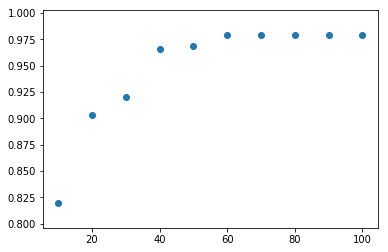

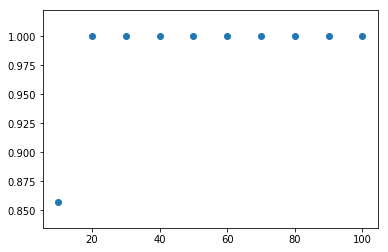

In [0]:
print("Started Task:", 1)

# uploaded = files.upload()
# for name, data in uploaded.items():
#   print (name)

# a = b
learning_rate = 0.001#0.1
anneal_rate = 10
anneal_stop_epoch = 100 #100
max_grad_norm=40.0
evaluation_interval=10
batch_size=32
hops=3
epochs=100
embedding_size=200
memory_size=40
task_id=1
random_state=10


# train_data = open('true_data_list.txt','r').readlines()
train_data2 = open('unary_fact_ext','r').readlines()


# train_data = train_data[:10000]
# train_data  = train_data.split('\n')

# task data
train2, test2 = load_task3(train_data2)

train_data = None
# data = train + test
data2 = train2 + test2


# all should be individual 1d lists, not [[]] type
vocab = sorted(reduce(lambda x, y: x | y, (set(list(s) + q + a) for s, q, a, _ in data2)))
vocab.extend(keyword_dict.keys())

edata = [tokenize(p.replace('\n','')) for p in evaluate_data]
edata = [item for sublist in edata for item in sublist]
vocab.extend(edata)

edata = [tokenize(p.replace('\n','')) for p in evaluate_rules]
edata = [item for sublist in edata for item in sublist]
vocab.extend(edata)

vocab = list(set(vocab))
edata= None
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))

max_story_size = max(map(len, (s for s, _, _, _ in data2)))
mean_story_size = int(np.mean([ len(s) for s, _, _, _ in data2 ]))
sentence_size = 1
query_size = max(map(len, (q for _, q, _, _ in data2)))
memory_size = min(memory_size, max_story_size)

print('word_ids', len(word_idx))
# Add time words/indexes
for i in range(memory_size*2):
    word_idx['time{}'.format(i+1)] = 'time{}'.format(i+1)
print('word_ids2', len(word_idx))
    

vocab_size = len(word_idx) + 1 # +1 for nil word
sentence_size = max(query_size, sentence_size) # for the position
sentence_size += 1  # +1 for time words

print("Longest sentence length", sentence_size)
print("Longest story length", max_story_size)
print("Average story length", mean_story_size)

!free -g

# train/validation/test sets
# S, Q, A = vectorize_datas(train, word_idx, sentence_size, memory_size)
S2, Q2, A2 = vectorize_datas(train2, word_idx, sentence_size, memory_size)


!free -g
# trainS, valS, trainQ, valQ, trainA, valA = cross_validation.train_test_split(S, Q, A, test_size=.1, random_state=random_state)
# trainS = S
# trainQ = Q
# trainA = A
# S = Q = A = None
# testS, testQ, testA = vectorize_datas(test, word_idx, sentence_size, memory_size)

# trainS2, valS2, trainQ2, valQ2, trainA2, valA2 = cross_validation.train_test_split(S2, Q2, A2, test_size=.1, random_state=random_state)
trainS2 = S2
trainQ2 = Q2
trainA2 = A2
S2 = Q2 = A2 = None
testS2, testQ2, testA2 = vectorize_datas(test2, word_idx, sentence_size, memory_size)

trainS2shape = np.array(trainS2).shape
testS2shape = np.array(testS2).shape

# print(testS2[0])

print("Training set shape", trainS2shape)

# params
n_train = trainS2shape[0]
n_test = testS2shape[0]
# n_val = valS2.shape[0]

print("Training Size", n_train)
# print("Validation Size", n_val)
print("Testing Size", n_test)

print("Training labels shape", trainA2.shape)

train_labels2 = np.argmax(trainA2.reshape(-1,memory_size),axis=1)
# np.argmax(trainA, axis=1)
# np.array(np.argmax(trainA.reshape(2,-1,vocab_size),axis=2)).reshape(-1,2)
print('train_labels',train_labels2.shape,'\n',train_labels2[0])

# trainA = trainA.reshape(-1,vocab_size)
# test_labels = np.array(np.argmax(testA.reshape(-1,vocab_size),axis=1))
# val_labels = np.array(np.argmax(valA.reshape(-1,vocab_size),axis=1))

trainA2 = trainA2.reshape(-1,memory_size)
test_labels2 = np.array(np.argmax(testA2.reshape(-1,memory_size),axis=1))
# val_labels2 = np.array(np.argmax(valA2.reshape(-1,vocab_size),axis=1))


tf.set_random_seed(random_state)

batches = zip(range(0, n_train-batch_size, batch_size), range(batch_size, n_train, batch_size))
batches = [(start, end) for start, end in batches]

batches2 = zip(range(0, n_train-batch_size, batch_size), range(batch_size, n_train, batch_size))
batches2 = [(start, end) for start, end in batches]


model = None
val_acc_list = list()
train_acc_list = list()
ep_list= list()

val_acc_list2 = list()
train_acc_list2 = list()
ep_list2 = list()
lr_list = list()

tf.reset_default_graph()
sess2 = tf.Session()

# with tf.Session() as sess:
print ('batch_size, vocab_size, sentence_size, memory_size, embedding_size, hops, max_grad_norm\n',batch_size, vocab_size, sentence_size, memory_size, embedding_size, hops, max_grad_norm)
model2 = MemN2N(batch_size, vocab_size, sentence_size, memory_size, embedding_size, session=sess2,
               hops=hops, max_grad_norm=max_grad_norm)
     

train_acc2 = 0.0    
# multiple word
for t in range(1, epochs+1):
    # Stepped learning rate
#     if t - 1 <= anneal_stop_epoch:
#         anneal = 2.0 ** ((t - 1) // anneal_rate)
#     else:
#         anneal = 2.0 ** (anneal_stop_epoch // anneal_rate)
    anneal = 1.0    
    lr = learning_rate / anneal
    
    np.random.shuffle(batches)
    total_cost2 = 0.0
    
    for start, end in batches:
        s2 = trainS2[start:end]
        q2 = trainQ2[start:end]
        a2 = trainA2[start:end]

#         print('s2', s2)
        cost_t2 = model2.batch_fit(s2, q2, a2, lr)
        total_cost2 += cost_t2
        

    if t % evaluation_interval == 0:
        train_preds2 = []
        for start in range(0, n_train, batch_size):
            end = start + batch_size
            s2 = trainS2[start:end]
            q2 = trainQ2[start:end]
#             pred2 = model2.predict(s, q)

            if(len(s2)!=batch_size):
              continue

            pred2, att = model2.predict(s2, q2)
            train_preds2 += list(pred2)
#             print('train_preds\n',train_preds[:5] )
#             print('train_labels\n',train_labels[:5])

        train_acc2 = metrics.accuracy_score(np.array(train_preds2), train_labels2[:len(train_preds2)])
        train_acc_list2.append(train_acc2)  
        test_preds2, att =  model2.predict(testS2, testQ2)       
        val_acc2 = metrics.accuracy_score(test_preds2, test_labels2)
        val_acc_list2.append(val_acc2)  
        ep_list2.append(t)



test_preds2, att = model2.predict(testS2, testQ2)
test_acc2 = metrics.accuracy_score(test_preds2, test_labels2)
print("Testing Accuracy:", train_acc2, test_acc2)

# tp,fp, tn, fn = evaluate(evaluate_data, keyword_dict)
# precison = 1.0*tp/(tp+fp)
# print(tp,fp, tn, fn,precison)  

mpl.pyplot.scatter(ep_list2,train_acc_list2)
mpl.pyplot.show()

mpl.pyplot.scatter(ep_list2,val_acc_list2)
mpl.pyplot.show()

  


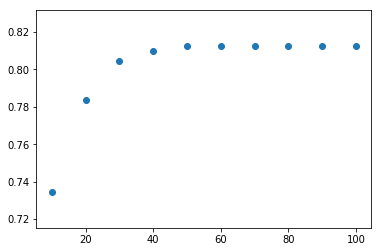

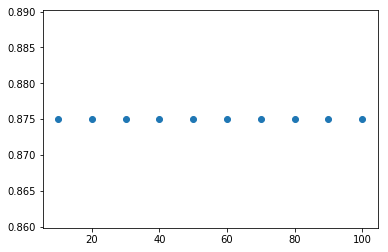

In [0]:
mpl.pyplot.scatter(ep_list2,train_acc_list2)
mpl.pyplot.show()

mpl.pyplot.scatter(ep_list2,val_acc_list2)
mpl.pyplot.show()

  


In [0]:
anneal_stop_epoch = 100
anneal_rate = 10
anneal_rates = [(i+1)*5 for i in range(200) if (i+1)*5<=200]
unknowns = [i+1 for i in range(10)]
anneal_stops = [(i+1)*100 for i in range(17) if (i+1)*100<=1600]
for an in unknowns:
#   anneal_rate = an
  lr_list = list()
  for t in range(1, epochs+1):
      # Stepped learning rate
      if t - 1 <= anneal_stop_epoch:
          anneal = 1.2 ** ((t - 1) // anneal_rate)
      else:
          anneal = 1.2 ** (anneal_stop_epoch // anneal_rate)
      lr = learning_rate / anneal
      lr_list.append(lr)

  mpl.pyplot.scatter([i for i in range(1600)],lr_list)
  mpl.pyplot.show()    
    

In [0]:
log_info = 1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_attention(in_seq, out_seq, attentions):
    """ From http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html"""

    out_seq = out_seq
    attentions = attentions
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
#     fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([' '] + [str(x) for x in in_seq], rotation=90)
    ax.set_yticklabels([' '] + [str(x) for x in out_seq])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

qKey 1025#0
pos_rules ['value x']
line In the figure above , what is the value of x ?
keysIn ['x']
tempQ x
gen_rule x   value


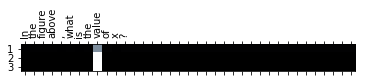

wordId 10
inc_over 1 0
qKey 1027#1
pos_rules ['value v']
line What is the value of v ?
keysIn ['v']
tempQ v
gen_rule v   value


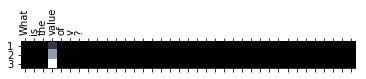

wordId 5
inc_over 2 0
qKey 1030#0
pos_rules ['value v', 'quadrilateral PQRS']
line In quadrilateral PQRS above , what is the value of v ?
keysIn ['PQRS', 'v']
tempQ PQRS
gen_rule PQRS   quadrilateral


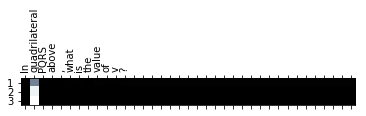

wordId 2
inc_over 3 0
tempQ v
gen_rule v   value


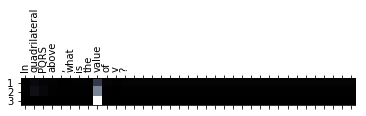

wordId 10
inc_over 4 0
qKey 1031#0
pos_rules ['point O', 'line AB']
line In the figure above , point O lies on line AB .
keysIn ['AB', 'O']
tempQ O
gen_rule O   point


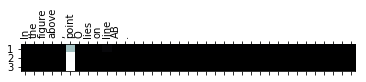

wordId 6
inc_over 5 0
tempQ AB
gen_rule AB   line


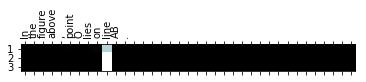

wordId 10
inc_over 6 0
qKey 1031#1
pos_rules ['value x']
line What is the value of x ?
keysIn ['x']
tempQ x
gen_rule x   value


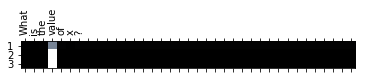

wordId 5
inc_over 7 0
qKey 1032#0
pos_rules ['triangle ABC', 'angle BAC', 'point D']
line In triangle ABC above , the bisector of angle BAC is perpendicular to BC at point D .
keysIn ['ABC', 'BAC', 'D', 'BC']
tempQ ABC
gen_rule ABC   triangle


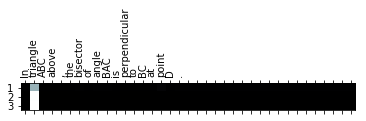

wordId 2
inc_over 8 0
tempQ BAC
gen_rule BAC   angle


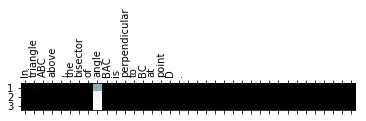

wordId 9
inc_over 9 0
tempQ BC
gen_rule BC   triangle


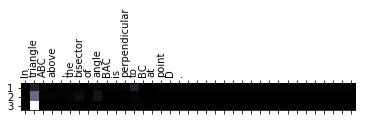

wordId 13
inc fp  1032#0   1
inc_over 9 1
tempQ D
gen_rule D   point


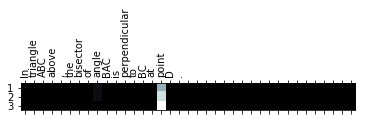

wordId 16
inc_over 10 1
qKey 1032#1
pos_rules ['angle BAC']
line If @s_0 holds and @s_1 holds , what is the measure of angle BAC ?
keysIn ['BAC']
tempQ BAC
gen_rule BAC   angle


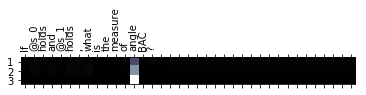

wordId 13
inc_over 11 1
qKey 1035#1
pos_rules ['value y']
line What is the value of y ?
keysIn ['y']
tempQ y
gen_rule y   value


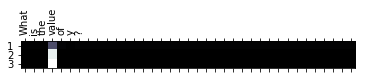

wordId 5
inc_over 12 1
qKey 1037#0
pos_rules ['radius r', 'center P']
line In the figure above , the circle has center P and radius r .
keysIn ['P', 'r']
tempQ P
gen_rule P   center


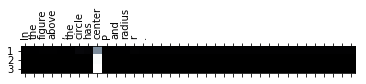

wordId 9
inc_over 13 1
tempQ r
gen_rule r   circle


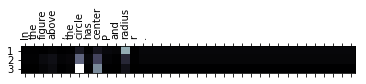

wordId 12
inc fp  1037#0   2
inc_over 13 2
inc fn 1
qKey 1037#1
pos_rules ['Lines AB', 'Lines AC']
line Lines AB and AC are tangent to the circle .
keysIn ['AC', 'AB']
tempQ AB
gen_rule AB   Lines


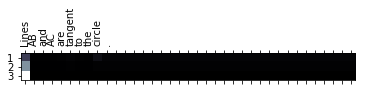

wordId 1
inc_over 14 2
tempQ AC
gen_rule AC   Lines


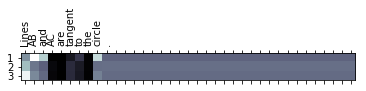

wordId 3
inc_over 15 2
qKey 1037#2
pos_rules ['segment AC', 'angle PMC', 'angle MPC', 'segment PA', 'Midpoint M']
line If M is the midpoint of segment AC and the measure of angle PMC equals the measure of angle MPC , what is the length , in terms of r , of segment PA ?
keysIn ['AC', 'PA', 'M', 'MPC', 'PMC', 'r']
tempQ M
gen_rule M   segment


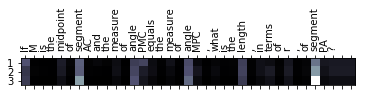

wordId 1
inc fp  1037#2   3
inc_over 15 3
tempQ AC
gen_rule AC   segment


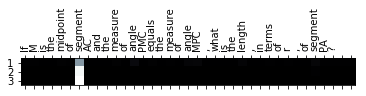

wordId 7
inc_over 16 3
tempQ PMC
gen_rule PMC   angle


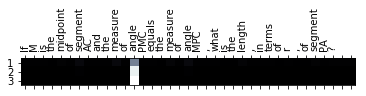

wordId 13
inc_over 17 3
tempQ MPC
gen_rule MPC   angle


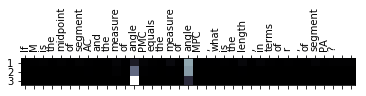

wordId 19
inc_over 18 3
tempQ r
gen_rule r   angle


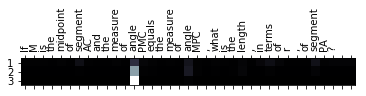

wordId 29
inc fp  1037#2   4
inc_over 18 4
tempQ PA
gen_rule PA   segment


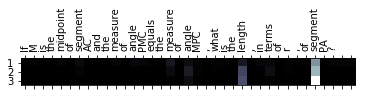

wordId 33
inc_over 19 4
inc fn 2
qKey 963#0
pos_rules ['lines l', 'point Q', 'lines k']
line In the figure above , lines l and k intersect at point Q .
keysIn ['Q', 'l', 'k']
tempQ l
gen_rule l   lines


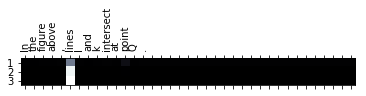

wordId 6
inc_over 20 4
tempQ k
gen_rule k   lines


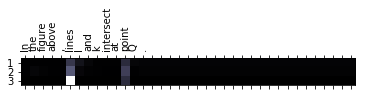

wordId 8
inc_over 21 4
tempQ Q
gen_rule Q   point


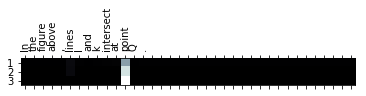

wordId 12
inc_over 22 4
qKey 963#1
pos_rules ['value x']
line If @s_0 holds and @s_1 holds , what is the value of x ?
keysIn ['x']
tempQ x
gen_rule x   and


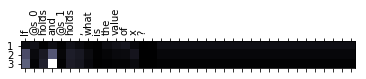

wordId 12
inc fp  963#1   5
inc_over 22 5
qKey 968#0
pos_rules ['triangle ABC', 'center O', 'diameter AC']
line In the figure above , triangle ABC is inscribed in the circle with center O and diameter AC .
keysIn ['AC', 'ABC', 'O']
tempQ ABC
gen_rule ABC   triangle


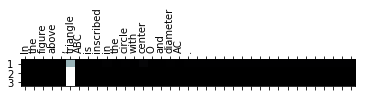

wordId 6
inc_over 23 5
tempQ O
gen_rule O   center


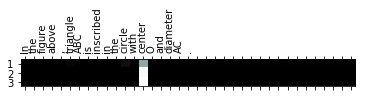

wordId 14
inc_over 24 5
tempQ AC
gen_rule AC   diameter


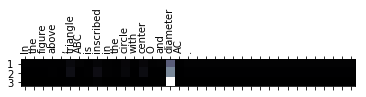

wordId 17
inc_over 25 5
qKey 968#1
pos_rules ['angle ABO']
line If @s_0 holds , what is the degree measure of angle ABO ?
keysIn ['ABO']
tempQ ABO
gen_rule ABO   of


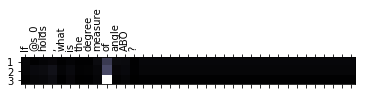

wordId 11
inc fp  968#1   6
inc_over 25 6
inc fn 3
qKey 969#0
pos_rules ['line CD', 'line AB', 'line EF']
line In the figure above , line AB , line CD , and line EF intersect at P .
keysIn ['P', 'AB', 'EF', 'CD']
tempQ AB
gen_rule AB   line


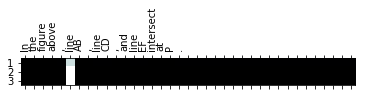

wordId 6
inc_over 26 6
tempQ CD
gen_rule CD   line


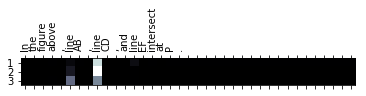

wordId 9
inc_over 27 6
tempQ EF
gen_rule EF   line


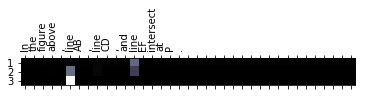

wordId 13
inc_over 28 6
tempQ P
gen_rule P   line


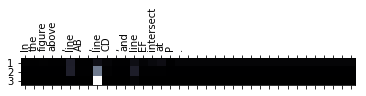

wordId 16
inc fp  969#0   7
inc_over 28 7
qKey 969#1
pos_rules ['value x']
line If @s_0 holds , @s_1 holds , @s_2 holds , @s_3 holds , and @s_4 holds , what is the value of x ?
keysIn ['x']
tempQ x
gen_rule x   @s_3


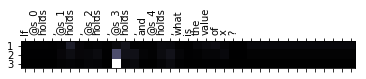

wordId 22
inc fp  969#1   8
inc_over 28 8
qKey 1466#1
pos_rules ['triangle RST']
line The area of triangle RST is 7 and @s_0 holds .
keysIn ['RST']
tempQ RST
gen_rule RST   triangle


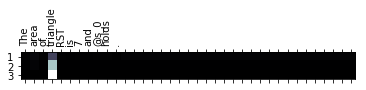

wordId 4
inc_over 29 8
qKey 1466#2
pos_rules ['area PQRS']
line What is the area of PQRS ?
keysIn ['PQRS']
tempQ PQRS
gen_rule PQRS   area


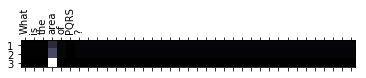

wordId 5
inc_over 30 8
qKey 1467#0
pos_rules ['point B', 'side AC']
line In the figure above , point B lies on side AC .
keysIn ['AC', 'B']
tempQ B
gen_rule B   point


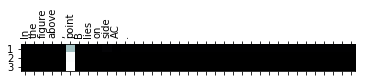

wordId 6
inc_over 31 8
tempQ AC
gen_rule AC   side


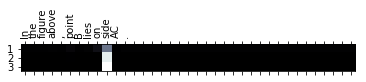

wordId 10
inc_over 32 8
qKey 1467#1
pos_rules ['value y']
line If @s_0 holds , what is one possible value of y ?
keysIn ['y']
tempQ y
gen_rule y   of


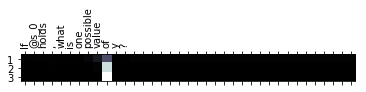

wordId 10
inc fp  1467#1   9
inc_over 32 9
qKey 1468#0
pos_rules ['sides BD', 'rectangle ABDF', 'midpoints C', 'midpoints E', 'sides DF']
line In rectangle ABDF above , C and E are midpoints of sides BD and DF , respectively .
keysIn ['BD', 'DF', 'C', 'E', 'ABDF']
tempQ ABDF
gen_rule ABDF   rectangle


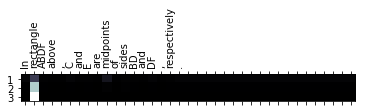

wordId 2
inc_over 33 9
tempQ C
gen_rule C   midpoints


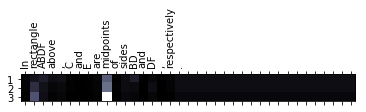

wordId 5
inc_over 34 9
tempQ E
gen_rule E   rectangle


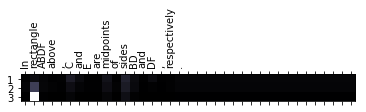

wordId 7
inc fp  1468#0   10
inc_over 34 10
tempQ BD
gen_rule BD   sides


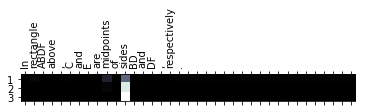

wordId 12
inc_over 35 10
tempQ DF
gen_rule DF   sides


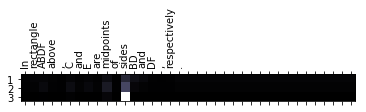

wordId 14
inc_over 36 10
inc fn 4
qKey 1469#0
pos_rules ['rectangle ABCD', 'area v']
line In rectangle ABCD above , the area of the shaded region is given by v .
keysIn ['ABCD', 'v']
tempQ ABCD
gen_rule ABCD   rectangle


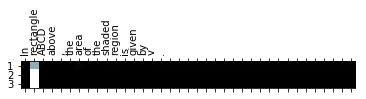

wordId 2
inc_over 37 10
tempQ v
gen_rule v   area


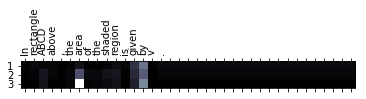

wordId 14
inc_over 38 10
qKey 1469#1
pos_rules ['rectangle ABCD', 'area v']
line If the area of the shaded region is v , what is the total area , to the nearest whole number , of the unshaded regions of rectangle ABCD ?
keysIn ['ABCD', 'v']
tempQ v
gen_rule v   area


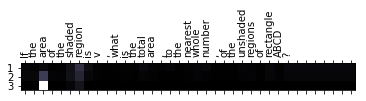

wordId 8
inc_over 39 10
tempQ ABCD
gen_rule ABCD   rectangle


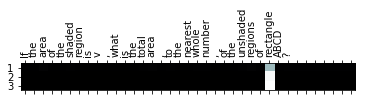

wordId 28
inc_over 40 10
qKey 1472#1
pos_rules ['radii PA', 'Point P', 'radii PB']
line Point P is the center of the large circle and PA and PB are radii .
keysIn ['PB', 'P', 'PA']
tempQ P
gen_rule P   Point


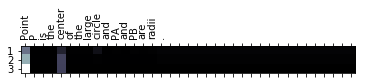

wordId 1
inc_over 41 10
tempQ PA
gen_rule PA   center


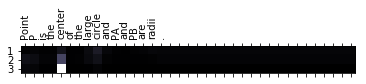

wordId 10
inc fp  1472#1   11
inc_over 41 11
tempQ PB
gen_rule PB   center


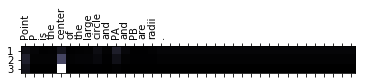

wordId 12
inc fp  1472#1   12
inc_over 41 12
inc fn 5
inc fn 6
qKey 1473#0
pos_rules ['diameter AB', 'center O']
line In the figure above , the circle with center O has radius 7 , AB is a diameter , and @s_0 holds .
keysIn ['AB', 'O']
tempQ O
gen_rule O   center


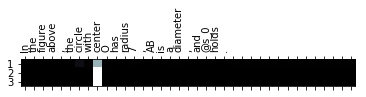

wordId 9
inc_over 42 12
tempQ AB
gen_rule AB   center


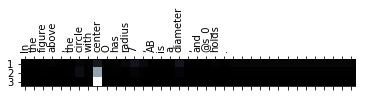

wordId 14
inc fp  1473#0   13
inc_over 42 13
inc fn 7
qKey 1473#1
pos_rules ['triangle ABC']
line What is the area of triangle ABC ?
keysIn ['ABC']
tempQ ABC
gen_rule ABC   triangle


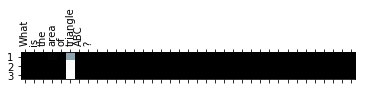

wordId 6
inc_over 43 13
qKey 1474#0
pos_rules ['lines l', 'lines m']
line In the figure above , lines l and m are not parallel .
keysIn ['l', 'm']
tempQ l
gen_rule l   lines


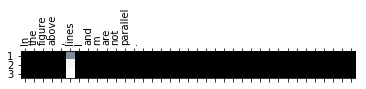

wordId 6
inc_over 44 13
tempQ m
gen_rule m   lines


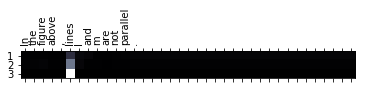

wordId 8
inc_over 45 13
qKey 1476#0
pos_rules ['value x']
line In the figure above , what is the value of x ?
keysIn ['x']
tempQ x
gen_rule x   value


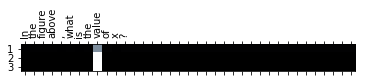

wordId 10
inc_over 46 13
qKey 1477#0
pos_rules ['perimeter p']
line The perimeter of the rectangle above is p and the area of the rectangle is 36 .
keysIn ['p']
tempQ p
gen_rule p   perimeter


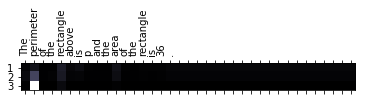

wordId 7
inc_over 47 13
qKey 1477#1
pos_rules ['value p', 'integers l', 'integers w']
line If l and w are integers , what is one possible value of p ?
keysIn ['l', 'p', 'w']
tempQ l
gen_rule l   If


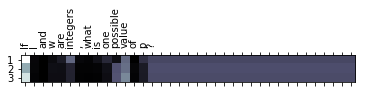

wordId 1
inc fp  1477#1   14
inc_over 47 14
tempQ w
gen_rule w   l


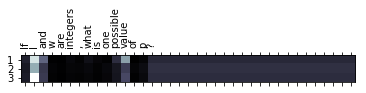

wordId 3
inc fp  1477#1   15
inc_over 47 15
tempQ p
gen_rule p   value


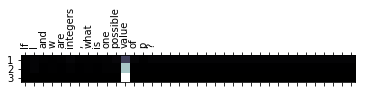

wordId 13
inc_over 48 15
inc fn 8
inc fn 9
qKey 1478#0
pos_rules ['value x', 'lines n', 'lines p', 'lines m', 'lines l']
line In the figure above , if the angle ( not shown ) where lines n and p intersect is twice as large as the angle ( also not shown ) where lines l and m intersect , what is the value of x ?
keysIn ['l', 'm', 'p']
tempQ p
gen_rule p   angle


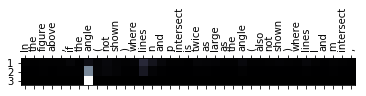

wordId 16
inc fp  1478#0   16
inc_over 48 16
tempQ l
gen_rule l   lines


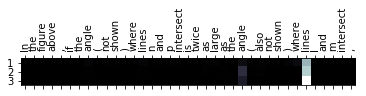

wordId 32
inc_over 49 16
tempQ m
gen_rule m   angle


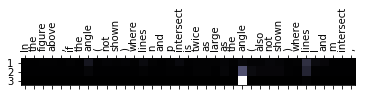

wordId 34
inc fp  1478#0   17
inc_over 49 17
inc fn 10
inc fn 11
qKey 1479#0
pos_rules ['points A', 'points B', 'center O']
line In the figure above , points A and B lie on the circle with center O .
keysIn ['A', 'B', 'O']
tempQ A
gen_rule A   points


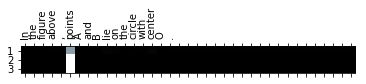

wordId 6
inc_over 50 17
tempQ B
gen_rule B   points


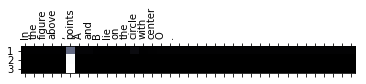

wordId 8
inc_over 51 17
tempQ O
gen_rule O   center


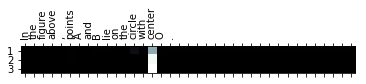

wordId 15
inc_over 52 17
qKey 1479#1
pos_rules ['value z']
line If @s_0 holds , what is the value of z ?
keysIn ['z']
tempQ z
gen_rule z   of


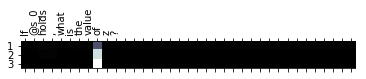

wordId 9
inc fp  1479#1   18
inc_over 52 18
inc fn 12
qKey 1481#0
pos_rules ['value x']
line If the perimeter of the rectangle above is 72 , what is the value of x ?
keysIn ['x']
tempQ x
gen_rule x   value


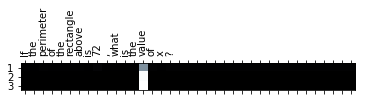

wordId 15
inc_over 53 18
qKey 1482#0
pos_rules ['triangle ABC', 'length AB', 'midpoint D']
line In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .
keysIn ['AC', 'ABC', 'D', 'AB']
tempQ ABC
gen_rule ABC   triangle


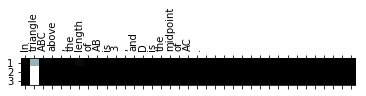

wordId 2
inc_over 54 18
tempQ AB
gen_rule AB   length


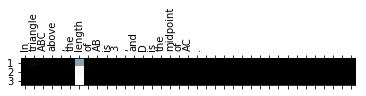

wordId 8
inc_over 55 18
tempQ D
gen_rule D   length


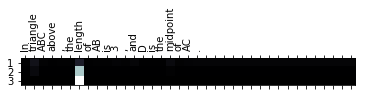

wordId 13
inc fp  1482#0   19
inc_over 55 19
tempQ AC
gen_rule AC   length


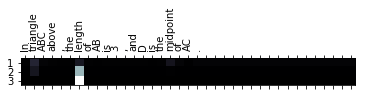

wordId 18
inc fp  1482#0   20
inc_over 55 20
inc fn 13
qKey 1482#1
pos_rules ['length BC']
line What is the length of BC ?
keysIn ['BC']
tempQ BC
gen_rule BC   length


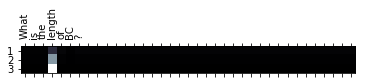

wordId 5
inc_over 56 20
qKey 971#0
pos_rules ['square ABCE', 'triangle CDE']
line In the figure above , CDE is an equilateral triangle and ABCE is a square with an area of 1 .
keysIn ['CDE', 'ABCE']
tempQ CDE
gen_rule CDE   area


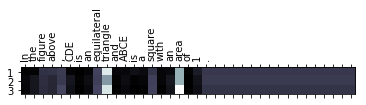

wordId 5
inc fp  971#0   21
inc_over 56 21
tempQ ABCE
gen_rule ABCE   triangle


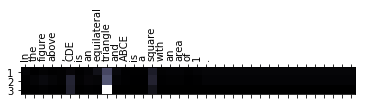

wordId 11
inc fp  971#0   22
inc_over 56 22
inc fn 14
inc fn 15
qKey 971#1
pos_rules ['polygon ABCDE']
line What is the perimeter of polygon ABCDE ?
keysIn ['ABCDE']
tempQ ABCDE
gen_rule ABCDE   polygon


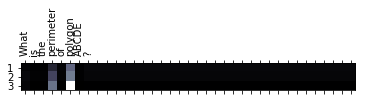

wordId 6
inc_over 57 22
qKey 1485#0
pos_rules ['triangle CAF', 'rectangle CDEF', 'segment AD']
line In the figure above , if the area of triangle CAF is equal to the area of rectangle CDEF , what is the length of segment AD ?
keysIn ['CDEF', 'CAF', 'AD']
tempQ CAF
gen_rule CAF   triangle


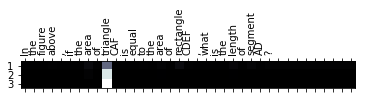

wordId 10
inc_over 58 22
tempQ CDEF
gen_rule CDEF   rectangle


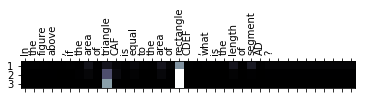

wordId 18
inc_over 59 22
tempQ AD
gen_rule AD   segment


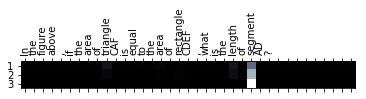

wordId 26
inc_over 60 22
60 22 0 15 0.731707317073 0.8 0.764331210191


In [0]:
# In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD
import re


def predictLong(se, q_position=-1):
    raws = se.split('##')[0].split()
    #   print('raws', raws)
    testS, testQ = se.split('##')
    splitQ = testQ.split(' ')
    tempQ = ' '.join(splitQ[:2])
    tempS = testS + '##' + 'point '+ tempQ 
#     print('tempS', tempS)
#     print('parse_stories3([tempS])', np.array(parse_stories3([tempS])).shape, parse_stories3([tempS]))

    s, q, a, q_position = parse_stories3([tempS], q_position)[0]
    s, q, a = vectorize_data(s, q, a, word_idx, sentence_size, memory_size, q_position)
    print ('tempQ',tempQ)
#     print('s1',s)
#     print('q1',q)
#     print('a1',a)
#     print('q_position',q_position)
    a1, att = model2.predict(s, q)
    att = att.reshape(3, memory_size)
    #   print('att', att.shape)

    #   print('a12', a1)
    if (a1[0] + 1 > len(raws)):
        return [0]
    if (log_info):
        print('gen_rule', tempQ, ' ', raws[int(a1[0])])
    plot_attention(raws, ['1', '2', '3'], att)
    return a1


def evaluate(lines, keyword_dict, rule_dict=rule_dict):
    single_rule_list = list()
    qs = list()
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    selected_rules = list()
    for line in lines:
        #     line.replace('\n','')
        #     line = line[:-1]


        qKey = line.split('##')[0]
        print('qKey',qKey)

        pos_rules = list()
        if qKey in rule_dict.keys():
            pos_rules = rule_dict[qKey]

        pos_rule_encs = list()
        pos_rule_encs2 = list()

        for rule in pos_rules:
#             if(log_info):
#                   print('rule', rule)
            rule_words = rule.split(' ')
#             print('rule_words', rule_words)
            rule1 = [rule_words[0], rule_words[1]]

            #       print('before',[rule_word.replace('@','') for rule_word in rule.split(' ')])
            #       rule_words1 = ''.join([str(word_idx[rule_word.replace('@','')]) for rule_word in rule1])
            rule_words1 = ''.join([str(word_idx[rule_word.replace('@', '')]) for rule_word in rule1])

            lss1 = ''.join(str(rule_words1))

            #       print('lss',lss1, lss2)
            pos_rule_encs.append(lss1)
        if (log_info):
            print('pos_rules', pos_rules)
        # print('pos_rules_encs',pos_rule_encs)

        line = line.split('##')[1]
        if (log_info):
            print('line', line)
        words = line.split(' ')

        #   pruning
        if (len(words) > memory_size):
            words = words[:memory_size]
            line = ' '.join(words)

        keysIn = list(set([x for x in re.findall(r'\b([A-Z]+)\b', line) if x.strip()]))
        if re.search(r'\bx\b', line):
            keysIn.append('x')
        if re.search(r'\by\b', line):
            keysIn.append('y')
        if re.search(r'\bz\b', line):
            keysIn.append('z')
        if re.search(r'\bl\b', line):
            keysIn.append('l')
        if re.search(r'\bm\b', line):
            keysIn.append('m')
        if re.search(r'\bp\b', line):
            keysIn.append('p')
        if re.search(r'\br\b', line):
            keysIn.append('r')
        if re.search(r'\bo\b', line):
            keysIn.append('o')
        if re.search(r'\bk\b', line):
            keysIn.append('k')
        if re.search(r'\bw\b', line):
            keysIn.append('w')
        if re.search(r'\bv\b', line):
            keysIn.append('v')
#         keysIn.append([x for x in re.findall(r'\bx\b', line) if x.strip()]) 
        print('keysIn', keysIn)
        keyword_dict = {key: 0 for key in keysIn}

        for word in words:
            if (word in keysIn):
                keyword_dict[word] += 1

        for wordId in range(len(words)):

            #       print('wordId', wordId)
            word = words[wordId]
            #       print(' word ', word)
            if word in keyword_dict.keys() and keyword_dict[word] != 0:
                a1 = predictLong(line + ' ##' + word, wordId)
                print('wordId', wordId)
                pred_word = str(words[a1[0]])
                #         print('pred_word ', pred_word)
                # print('a1', a1)
                word_id = word_idx[word]
                lss3 = ''.join([str(word_idx[words[a1[0]].replace('@', '')]), str(word_id) ])
                #         single_rule_list.append(qKey+'##'+word+' ' + word_idx.keys()[word_idx.values().index(a1)])
                single_rule_list.append(qKey + '##' + word + ' ' + pred_word)
                selected_rules.append(lss3)
                #         predicted_rule = word + ' ' +a1
                if containList(lss3, pos_rule_encs, 'tp'):
                    tp = tp + 1
                else:
                    fp = fp + 1
                    qKey
                    print('inc fp ',qKey, ' ' ,  fp)
                    
                if (log_info):
                    print('inc_over', tp, fp)

        for ruleId in range(len(pos_rule_encs)):
            #       print('ruleId', ruleId)
            #       print('pos_rule_encs', pos_rule_encs, )
            if not containList(pos_rule_encs[ruleId], selected_rules, 'fp'):
#                 print('pos_rule_encs[ruleId], selected_rules', pos_rule_encs[ruleId], selected_rules)
                fn = fn + 1
                print('inc fn', fn)

    single_rule_list = list(set(single_rule_list))
    predict_single_rule_file = open("predict_single_rule_ext_file_mm.txt", "w+")
    for v in single_rule_list:
        predict_single_rule_file.write(v)
        predict_single_rule_file.write('\n')
    predict_single_rule_file.close()

    return tp, fp, tn, fn


def containList(list1, lists, a):
    if (list1 in lists):
        return True
    return False


# predictLong('In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .##midpoint D AC')
# predictLong('What is the length of segment AB ?##length AB')

tp, fp, tn, fn = evaluate(evaluate_data, keyword_dict)
precison = 1.0 * tp / (tp + fp)
recall = 1.0 * tp / (tp + fn)
f1Score = 2.0 * precison * recall / (precison + recall)

print(tp, fp, tn, fn, precison, recall, f1Score)


In [0]:
60 22 0 15 0.731707317073 0.8 0.764331210191
55 25 0 20 0.6875 0.733333333333 0.709677419355
54 25 0 37 0.683544303797 0.593406593407 0.635294117647

In [0]:
re.search(r'\bv_0\b', ' What is the value of @v_0 ?')

In [0]:
inc 55 43
55 43 0 80 0.561224489796 0.407407407407 0.472103004292

tempS line O is parallel to line AB ? ##point AB
parse_stories3([tempS]) (0,) []
tempQ AB
s1 [[[447, 520], [419, 521], [356, 522], [107, 523], [10, 524], [447, 525], [476, 526], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]
q1 [[476, 524]]
a1 [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])]
q_position 4
gen_rule AB   line


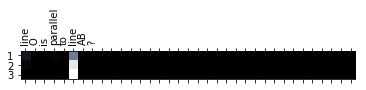

tempS circle O is parallel to line AB ? ##point O
parse_stories3([tempS]) (0,) []
tempQ O
s1 [[[268, 524], [419, 525], [356, 526], [107, 527], [10, 528], [447, 529], [476, 530], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]
q1 [[419, 524]]
a1 [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])]
q_position 0
gen_rule O   line


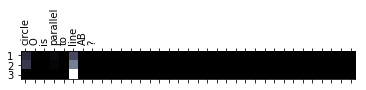

array([5])

In [0]:
# predictLong('What is the length of segment AB ? ##length') 
predictLong('line O is parallel to line AB ? ##AB',4) 
 
predictLong('circle O is parallel to line AB ? ##O',0) 


In [0]:
line1 = ['1025#0##BCA is a triangle']
evaluate(line1,keyword_dict)

pos_rules ['value x']
line BCA is a triangle


In [0]:
keyword_dict

{'Circle': 1,
 'Diameter': 2,
 'Find': 1,
 'Line': 1,
 'Points': 1,
 'Rectangle': 1,
 'Segment': 1,
 'Triangle': 1,
 'Two': 1,
 'What': 0,
 'altitude': 2,
 'angle': 1,
 'angles': 1,
 'arc': 1,
 'arcs': 1,
 'area': 1,
 'average': 1,
 'be': 2,
 'center': 2,
 'chord': 2,
 'chords': 2,
 'circle': 1,
 'congruent': 2,
 'correct': 1,
 'degrees': 1,
 'diameter': 1,
 'equal': 2,
 'equals': 2,
 'equilateral': 1,
 'has': 2,
 'height': 1,
 'hypotenuse': 2,
 'intersect': 2,
 'intersects': 2,
 'is': 2,
 'isosceles': 1,
 'leg': 2,
 'length': 2,
 'lies': 2,
 'line': 1,
 'lines': 1,
 'measure': 1,
 'measures': 1,
 'meet': 2,
 'midpoints': 2,
 'not': 1,
 'on': 2,
 'parallel': 2,
 'perimeter': 1,
 'perpendicular': 2,
 'point': 1,
 'points': 1,
 'quadrilateral': 1,
 'radius': 1,
 'ratio': 2,
 'rectangle': 1,
 'rhombus': 1,
 'right': 1,
 'secant': 2,
 'secants': 2,
 'sector': 1,
 'segment': 1,
 'side': 2,
 'sides': 2,
 'six': 1,
 'square': 1,
 'sum': 1,
 'tangent': 2,
 'tangents': 2,
 'trapezoid': 1,
 'tri

In [0]:
double_rule_list = list(set(double_rule_list))
for v in double_rule_list:
  print(v)

1470#1##is area What
1482#0##is AB length
1485#0##is area what
1484#3##is area What
1032#0##is D point
1476#0##is value what
1032#0##perpendicular BC point
968#1##is measure what
968#0##is O circle
974#0##is value what
1479#1##is value what
969#0##intersect AB EF
1020#1##is value What
1005#1##center A B
971#0##is area square
1037#1##tangent AB circle
1482#1##is length What
1037#2##is measure length
1027#1##is value What
1479#0##center O circle
1473#0##with AB O
1006#2##be length Which
1473#1##is area What
977#1##is measure What
975#1##is length what
968#0##center circle O
963#1##is value what
1481#0##is value what
1031#0##lies_on AB point
1477#1##is value what
1025#0##is value what
1019#1##is perimeter What
1473#0##center AB O
985#0##lies_on B AC
1031#1##is value What
1005#1##tangent A B
1035#1##is value What
995#1##is sum What
1473#0##is AB O
1467#0##lies_on B AC
1030#0##is value what
993#1##is value what
1037#2##equals length measure
1467#1##is value what
1151#0##is measure What
1037

In [0]:
np.sort([int(val) for val in word_idx.values() if val!='time1'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [0]:
vocab[1]

'illustrates'

In [0]:

for i in range(6):
  s = [[word_idx.keys()[word_idx.values().index(j)]] for j in testS[i][0] if j>0 and j<220]
  print (s)

[['The'], ['measure'], ['of'], ['angle'], ['BAC'], ['equals'], ['@'], ['v_0']]
[['In'], ['the'], ['figure'], ['above'], [','], ['point'], ['B'], ['lies'], ['on'], ['side'], ['AC']]
[['In'], ['rectangle'], ['ABDF'], ['above'], [','], ['C'], ['and'], ['E'], ['are'], ['midpoints'], ['of'], ['sides'], ['BD'], ['and'], ['DF'], [','], ['respectively']]
[['Point'], ['P'], ['is'], ['the'], ['center'], ['of'], ['the'], ['large'], ['circle'], ['and'], ['PA'], ['and'], ['PB'], ['are'], ['radii']]
[['In'], ['the'], ['figure'], ['above'], [','], ['the'], ['circle'], ['with'], ['center'], ['O'], ['has'], ['radius'], ['7'], [','], ['AB'], ['is'], ['a'], ['diameter'], [','], ['and'], ['@'], ['s_0'], ['holds']]
[['In'], ['the'], ['figure'], ['above'], [','], ['the'], ['circle'], ['with'], ['center'], ['O'], ['has'], ['radius'], ['7'], [','], ['AB'], ['is'], ['a'], ['diameter'], [','], ['and'], ['@'], ['s_0'], ['holds']]


In [0]:

for i in range(6):
  s = [[word_idx.keys()[word_idx.values().index(j)]] for j in testQ[i] if j>0 and j<7974]
  print (s)

[['equals']]
[['lies_on'], ['B']]
[['midpoints'], ['C']]
[['center'], ['P']]
[['has'], ['radius']]
[['center'], ['O']]


In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_preds[:6]]

['BAC', 'AC', 'D', 'circle', 'AB', 'AB']

In [0]:
from operator import __mul__
se = [1,2,3]
reduce(__mul__,se,1)

6

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:6]]

['measure', 'AC', 'BD', 'circle', '7', 'circle']

In [0]:
testS[5][0]
[j for j in train_labels[5][0]]

42894

In [0]:
testQ[5],trainQ[5],len([a for a in trainQ if sum(p>0 for p in a)>1])

(array([103,  59,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([166,  39,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 90)

In [0]:
word_idx.keys()[word_idx.values().index(3171)]


'In'

In [0]:
len(word_idx)

7974

In [0]:
import re
parse_stories(['In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD',
'In circle O , diameter AC is perpendicular to chord AD at E .##perpendicular AC AD'])

[([['In',
    'circle',
    'O',
    ',',
    'diameter',
    'AB',
    'is',
    'perpendicular',
    'to',
    'chord',
    'CD',
    'at',
    'E']],
  ['perpendicular', 'AB'],
  'CD'),
 ([['In',
    'circle',
    'O',
    ',',
    'diameter',
    'AC',
    'is',
    'perpendicular',
    'to',
    'chord',
    'AD',
    'at',
    'E']],
  ['perpendicular', 'AC'],
  'AD')]

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_preds[:5]]

[' l', 'le', ' O', 'CD', ' O']

In [0]:
for story in testS[:5]:
  for sentence in story:
    print ([word_idx.keys()[word_idx.values().index(i)] for i in sentence if i!=0 and i!=8010])



['In', 'circle', 'O', ',', 'diameter', 'IB', 'is', 'perpendicular', 'to', 'chord', 'IC', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IC', 'is', 'perpendicular', 'to', 'chord', 'ID', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'ID', 'is', 'perpendicular', 'to', 'chord', 'IE', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IE', 'is', 'perpendicular', 'to', 'chord', 'IF', 'at', 'E']
['In', 'circle', 'O', ',', 'diameter', 'IF', 'is', 'perpendicular', 'to', 'chord', 'IG', 'at', 'E']


In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:5]]

In [0]:
[word_idx.keys()[word_idx.values().index(i)] for i in test_labels[:5]]

['IC', 'ID', 'IE', 'IF', 'IG']

In [0]:
class AB(object):
  def __init__(self):
    self.asw = 5
  def getAs(self):
    return self.asw
  
errw = AB()
print(errw.getAs())

5


In [0]:
# np.argmax(train_preds[0])
# word_idx.keys()[word_idx.values().index(1325)]
len(train_preds)

1600

In [0]:
story12 =  ['The', 'diagram', 'below', 'illustrates', 'the', 'construction', 'of', 'line', 'PS', 'parallel', 'to', 'line', 'RQ', 'through', 'point', 'P']
query12 =  ['parallel']
answer12 =  ['PS']
story12.index(answer12[0])

story12.index(query12[0])

9

In [0]:
data2[0][0]
# max_story_size1 = max(map(len, (s for s, _, _ in data2)))
# mean_story_size = int(np.mean([ len(s) for s, _, _ in data2 ]))
# sentence_size = max(map(len, chain.from_iterable(s for s, _, _ in data2)))
# query_size = max(map(len, (q for _, q, _ in data2)))
# memory_size = min(memory_size, max_story_size)
np.array(trainS2).shape
trainS2[100]

[[522],
 [521],
 [520],
 [519],
 [518],
 [517],
 [136, 516],
 [515],
 [514],
 [513],
 [512],
 [419, 511],
 [510],
 [389, 509],
 [136, 508],
 [507],
 [506],
 [505],
 [504],
 [419, 503],
 [502],
 [407, 501],
 [500],
 [499],
 [498],
 [497],
 [496],
 [495],
 [136, 494],
 [493],
 [11, 492],
 [491],
 [490],
 [0],
 [0]]

In [0]:
len(word_idx)

559

pos_rules ['value x']
line In the figure above , what is the value of x ?
wordId 8
att [[[0.02767446 0.02775258 0.02808488 0.0276481  0.02783513 0.02783608
   0.02765748 0.02763407 0.02779131 0.02802508 0.04845458 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692 0.02806692
   0.02806692 0.02806692 0.02806692 0.02806692 0.02806692]]

 [[0.02723718 0.02723785 0.02723783 0.0272371  0.02723825 0.02723775
   0.02723751 0.02723709 0.0272394  0.02723959 0.07388205 0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391  0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391  0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391  0.0272391
   0.0272391  0.0272391  0.0272391  0.0272391  0.0272391 ]]

 [[0.02723439 0.02723439 0.02723439 0.02723439 0.02723439 0.02723439
   0.02723439 0.02723439 0.02723439 

ValueError: ignored

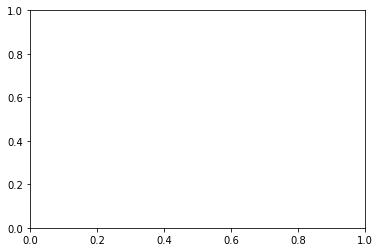

In [0]:
# In circle O , diameter AB is perpendicular to chord CD at E .##perpendicular AB CD    
import re



def predictLong(se, q_position = -1):
  raws = se.split('##')[0].split()
#   print('raws', raws)
  testS,testQ =  se.split('##')
  splitQ = testQ.split(' ')
  tempQ = ' '.join(splitQ[:2])
  tempS = testS+'##'+tempQ+' point'
#   print('tempS',tempS)
#   print('parse_stories2([tempS])',np.array(parse_stories2([tempS])).shape, parse_stories2([tempS]))
  
  s,q,a =  parse_stories3([tempS])[0]
  s,q,a = vectorize_data(s, q, a, word_idx, sentence_size,
                         memory_size, q_position = q_position )
#   print ('tempQ',tempQ)
#   print('s1',s)
  a1, att = model2.predict(s,q)
  print('att', att)
  plot_attention([[r] for r in raws],[['1'], ['2'], ['3']],  att)
#   print('a12', a1)
  if(a1[0]+1>len(raws)):
    return [0]
  if(log_info):
    print('rule1', tempQ,' ',raws[int(a1[0])])

  return a1
# #   print('s12',s)
# #   print('a12', a1)
# #   print ('rule', word_idx.keys()[word_idx.values().index(a1)])

#   if(a1[0]+1>len(raws)):
#     return 0,0
#   tempQ = tempQ+' '+ raws[int(a1[0])]
# #   print ('tempQ',tempQ)
#   tempS = testS+'##'+tempQ+' point'
# #   print ('tempS',tempS)
#   _,q,a =  parse_stories3([tempS])[0]
  
#   q = vectorize_question(s,q,a,word_idx, sentence_size, memory_size)
# #   print (s)
# #   print(q)
  
#   a2 = model2.predict(s,q)
# #   print ('rule',a1.shape,a2.shape)
# #   print('a2', a2)
#   if a1!=429 and a2!=429 and a2[0]<len(raws):
#     print('rule1', tempQ,' ',raws[int(a2[0])])
# #     print('rule1', word_idx.keys()[word_idx.values().index(a1)],' ',word_idx.keys()[word_idx.values().index(a2)])
#   return a1, a2
  
  
  
                          
#   print('lenrange',len(splitQ))
#   for i in range(len(splitQ)-1):
# #     print('i',i)
#     tempQ = ' '.join(splitQ[:i+1])
# #   'point'; a dummy answer
#     tempS = testS+'##'+tempQ+' point'
# #     print(tempS)
#     s,q,a =  parse_stories([tempS])[0]
# #     print('s',s)
#     s,q,a = vectorize_data(s,q,a,word_idx, sentence_size, memory_size)
# #     print('len1',len(s)) 
#     print (s)
#     print (q)
#     print ('pred',model.predict(s,q))
#   return s,q
# ad = predictLong('In circle O , diameter AB is perpendicular to chord CD at E .','perpendicular AB CD') 

# np.array(ad).shape,model.predict(s,q)
# model.predict(s,q)

def evaluate(lines,keyword_dict, rule_dict = rule_dict):
  single_rule_list = list()
  qs = list()
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  selected_rules = list()
  for line in lines:
#     line.replace('\n','')
#     line = line[:-1]


    qKey = line.split('##')[0]
#     print('qKey',qKey)
    
    pos_rules = list()
    if qKey in rule_dict.keys():
      pos_rules = rule_dict[qKey]      
    
    pos_rule_encs = list()
    pos_rule_encs2 = list()
    
    for rule in pos_rules:
#       if(log_info):
#             print('rule', rule)
      rule_words = rule.split(' ')
      rule1 = [rule_words[0],rule_words[1]]
      
#       print('before',[rule_word.replace('@','') for rule_word in rule.split(' ')])
#       rule_words1 = ''.join([str(word_idx[rule_word.replace('@','')]) for rule_word in rule1])
      rule_words1 = ''.join([str(word_idx[rule_word.replace('@','')]) for rule_word in rule1])
        
    
      lss1 = ''.join(str(rule_words1))
      
#       print('lss',lss1, lss2)
      pos_rule_encs.append(lss1)
    if(log_info):      
      print('pos_rules',pos_rules)
#     print('pos_rules_encs',pos_rule_encs)
    
    line = line.split('##')[1]
    if(log_info): 
      print('line',line)
    words = line.split(' ')
  
#   pruning
    if(len(words)>memory_size):
      words = words[:memory_size]
      line = ' '.join(words)
  
  
    for wordId in range(len(words)):
      
      word = words[wordId]
#       print(' word ', word)
      if word in keyword_dict.keys() and keyword_dict[word]==1:
        if(word=='on'):
          continue
          
        if((word.lower() in ['lies','lie']) or (word.lower()=='is' and words[wordId+1]=='on' )):
          word =word+'_on'
        print('wordId', wordId)
        a1= predictLong(line+' ##'+word, wordId)
        pred_word = str(words[a1[0]])
#         print('pred_word ', pred_word)
        if(a1 == [0] or (not pred_word.isalnum()) or(pred_word.islower() and len(pred_word)>1)):
          continue
#         print('a1', a1)
        word_id = word_idx[word]
        lss3 = ''.join([str(word_id), str(word_idx[words[a1[0]].replace('@','')]) ])
#         single_rule_list.append(qKey+'##'+word+' ' + word_idx.keys()[word_idx.values().index(a1)])
        single_rule_list.append(qKey+'##'+word+' ' + pred_word)
        selected_rules.append(lss1)
#         predicted_rule = word + ' ' +a1
        if containList(lss3, pos_rule_encs,'tp'):
          tp = tp+1
        else:
          fp = fp+1
        if(log_info):
          print('inc',tp,fp)    
          
    for ruleId in range(len(pos_rule_encs)):
#       print('ruleId', ruleId)    
#       print('pos_rule_encs', pos_rule_encs, )
      if not containList(pos_rule_encs[ruleId], selected_rules,'fp'):
        fn = fn+1

  single_rule_list = list(set(single_rule_list))
  predict_single_rule_file = open("predict_single_rule_ext_file_mm.txt", "w+")                              
  for v in single_rule_list:
    predict_single_rule_file.write(v)
    predict_single_rule_file.write('\n')
  predict_single_rule_file.close()   
                                
          
          
  return tp,fp, tn, fn 

def containList(list1, lists,a):
#   print(a,list1,'##',lists)
#   print('lists',lists)
#   print('list1',list1)
  
#   list_ind =int(''.join(str(x) for x in list1)) 
#   list_ints = list()
  
#   for i in lists:
# #     print('i',i)
# #     print('gen',int(''.join(str(x) for x in i)))
#     list_ints.append(''.join(str(x).strip()) for x in i if len(''.join(str(x)).strip())>0) 
  if (list1 in lists):
    return True
  return False



# predictLong('In triangle ABC above , the length of AB is 3 , and D is the midpoint of AC .##midpoint D AC') 
# predictLong('What is the length of segment AB ?##length AB') 

tp,fp, tn, fn = evaluate(evaluate_data, keyword_dict)
precison = 1.0*tp/(tp+fp)
recall = 1.0*tp/(tp+fn)
f1Score = 2.0*precison*recall/(precison+recall)

print(tp,fp, tn, fn,precison, recall, f1Score)


In [0]:
evaluate_rule_file_v1 = open("evaluate_rule_file_v1.txt", "w+") 
for qline in evaluate_data:
  qkey = qline.split('##')[0]
  if qkey not in rule_dict:
    continue
  rules = rule_dict[qkey]  
  evaluate_rule_file_v1.write(qline)
  evaluate_rule_file_v1.write('$$')
  for rule in rules:  
    evaluate_rule_file_v1.write('@')  
    evaluate_rule_file_v1.write(rule)
  evaluate_rule_file_v1.write('\n')
  